# Plots for  presentation  "Beyond Automatic Translation: Aligning Wikipedia sections across multiple languages"
https://www.mediawiki.org/wiki/Wikimedia_Research/Showcase#March_2018


* Visual representation of section alignment using fasttext and Babylon project (https://github.com/Babylonpartners/fastText_multilingual)


In [1]:
import json
from collections import Counter
import gzip
import json
import math
import numpy as np
from fastText_multilingual.fasttext import FastVector
import re

## Transform sentences in vectors

In [183]:
def createVector(sec1,vectors):
    """
    sec1 is a section title like 'Early Years'
    vectors is the fasttext vectorial representation for words, load with FastVector func
    For mor details about vectors check Babylon Project page 
    """
    sec1 = sec1.lower().split()
    sec1Vector  = np.zeros(300) + np.sum([vectors[word.lower()] for word in sec1 if word in vectors],axis=0)/len(sec1)
    return sec1Vector


## Loading sections to be evaluated and vector representation 
(sections can be pre-computed and read from a text file or spreadsheet)

In [159]:
secsPerlang = {}
vecsPerLang = {}
p = 0.75 #percentage of sections occurrences to be corevered 

for lang in ['en','es']:
    print(lang)

    sectionsAll = []
    #Load Sections
    with open('../gap/multiLanguageFromDumpsSec/sections-articles_%s.json' % lang) as f: 
        sections = json.load(f)
    ##get most frequent sections
    for secs in sections.values():
        for secName in secs:
                cleanSection = re.sub('[=\]\[]','',secName).strip()
                sectionsAll.append(cleanSection.strip())
    sectionsFreq = Counter(sectionsAll)
    total = sum(list(sectionsFreq.values()))
    acc =0
    secsToEval = []
    for n,(sec,freq) in enumerate(sectionsFreq.most_common()):
        acc+= freq
        secsToEval.append(sec)

        if acc/total > p: #using sections that cover 80% of total
                break
    ## Get fasttext vectors for lang
    wordVectors = FastVector(vector_file='fastText_multilingual/vectors/wiki.%s.vec' % lang)
    secsPerlang[lang] = secsToEval
    vecsPerLang[lang] = wordVectors

en
reading word vectors from fastText_multilingual/vectors/wiki.en.vec
es
reading word vectors from fastText_multilingual/vectors/wiki.es.vec


## Compute the embedding representation for section titles

In [165]:
embeddings = {}
for lang, secsSelected in secsPerlang.items():
    print(lang)
    embeddings[lang] = [createVector(s,vecsPerLang[lang]) for s in secsSelected]


en
es


## Project vectors in 2D using TSNE
Note that TSNE use some randomization, to get always the same results use random_state = constant

In [267]:
from sklearn.manifold import TSNE
X_tsne = TSNE(learning_rate=2000,random_state=34).fit_transform(embeddings['en']+embeddings['es'])


## Plotting
### Plot the 40 most frequent sections in English

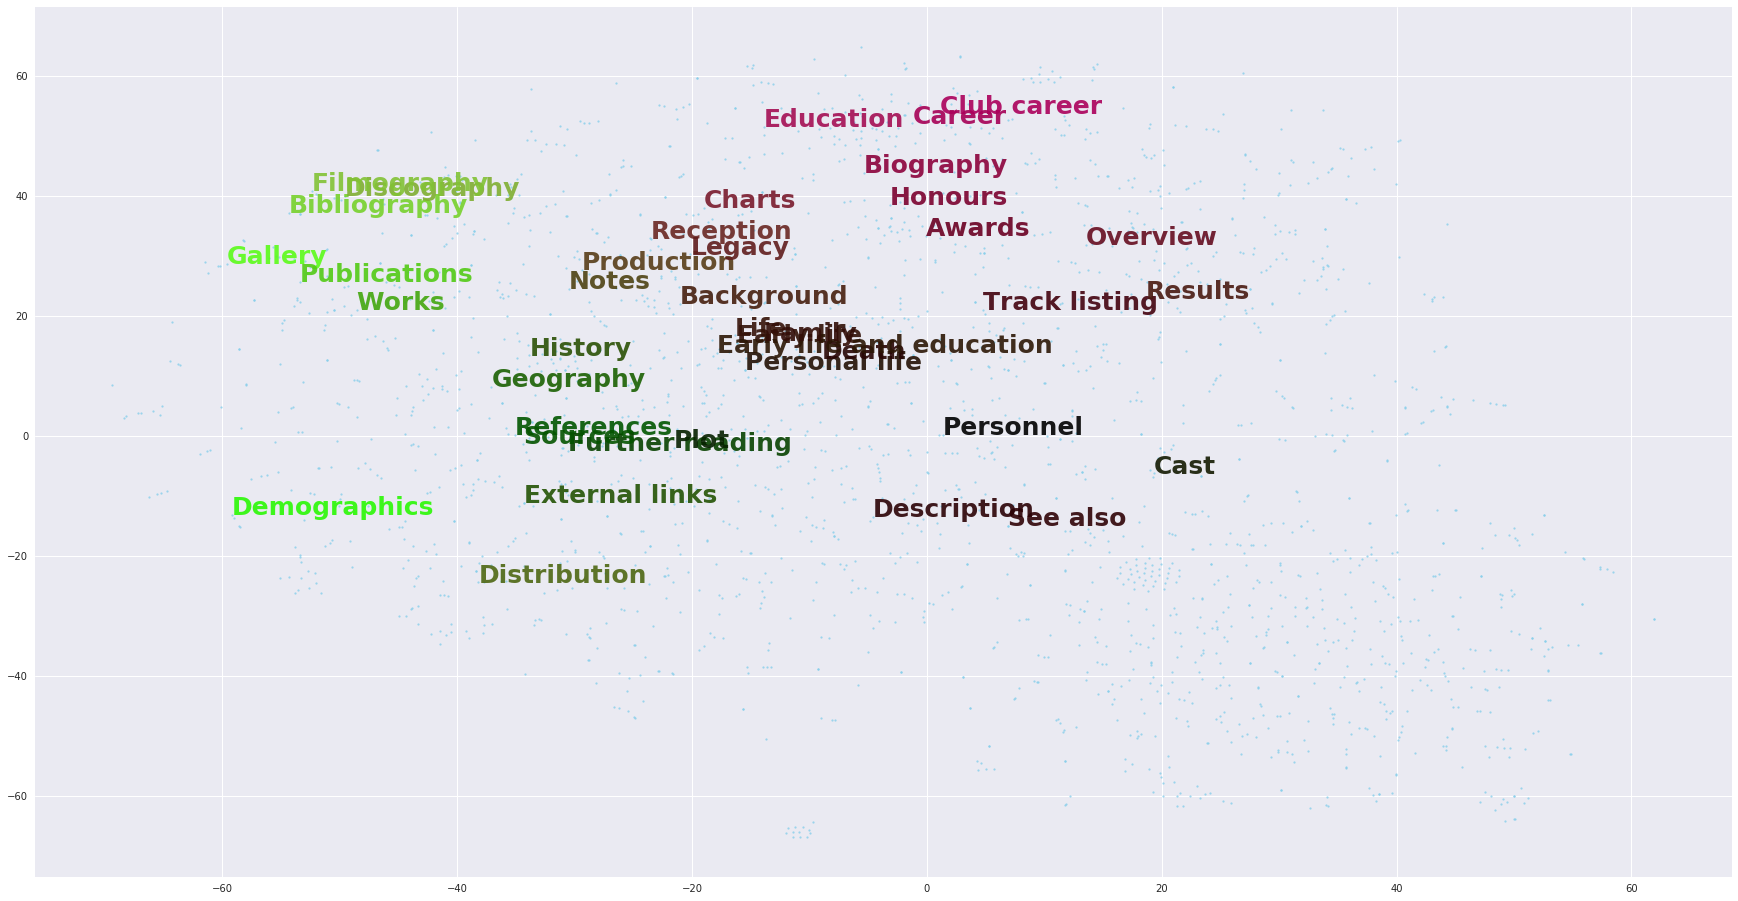

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16*1.9,16)})

p1=sns.regplot(x=X_tsne[:, 0], y=X_tsne[:, 1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':5})
#p1.axes.set_xlim(-40,60)
#p1.axes.set_ylim(-70,5)

for n,section in enumerate(secsPerlang['en'][0:40]):   
     p1.text(X_tsne[n,0], X_tsne[n,1], section, horizontalalignment='left', size=25, color=(abs(X_tsne[n,1])/80,(X_tsne[n,0]**2)/60**2,(X_tsne[n,1])**2/90**2),alpha=0.9, weight='bold')

p1.figure.savefig('SectionTSNE_en.png',bbox_inches='tight')


### Keep a subset of related section titles

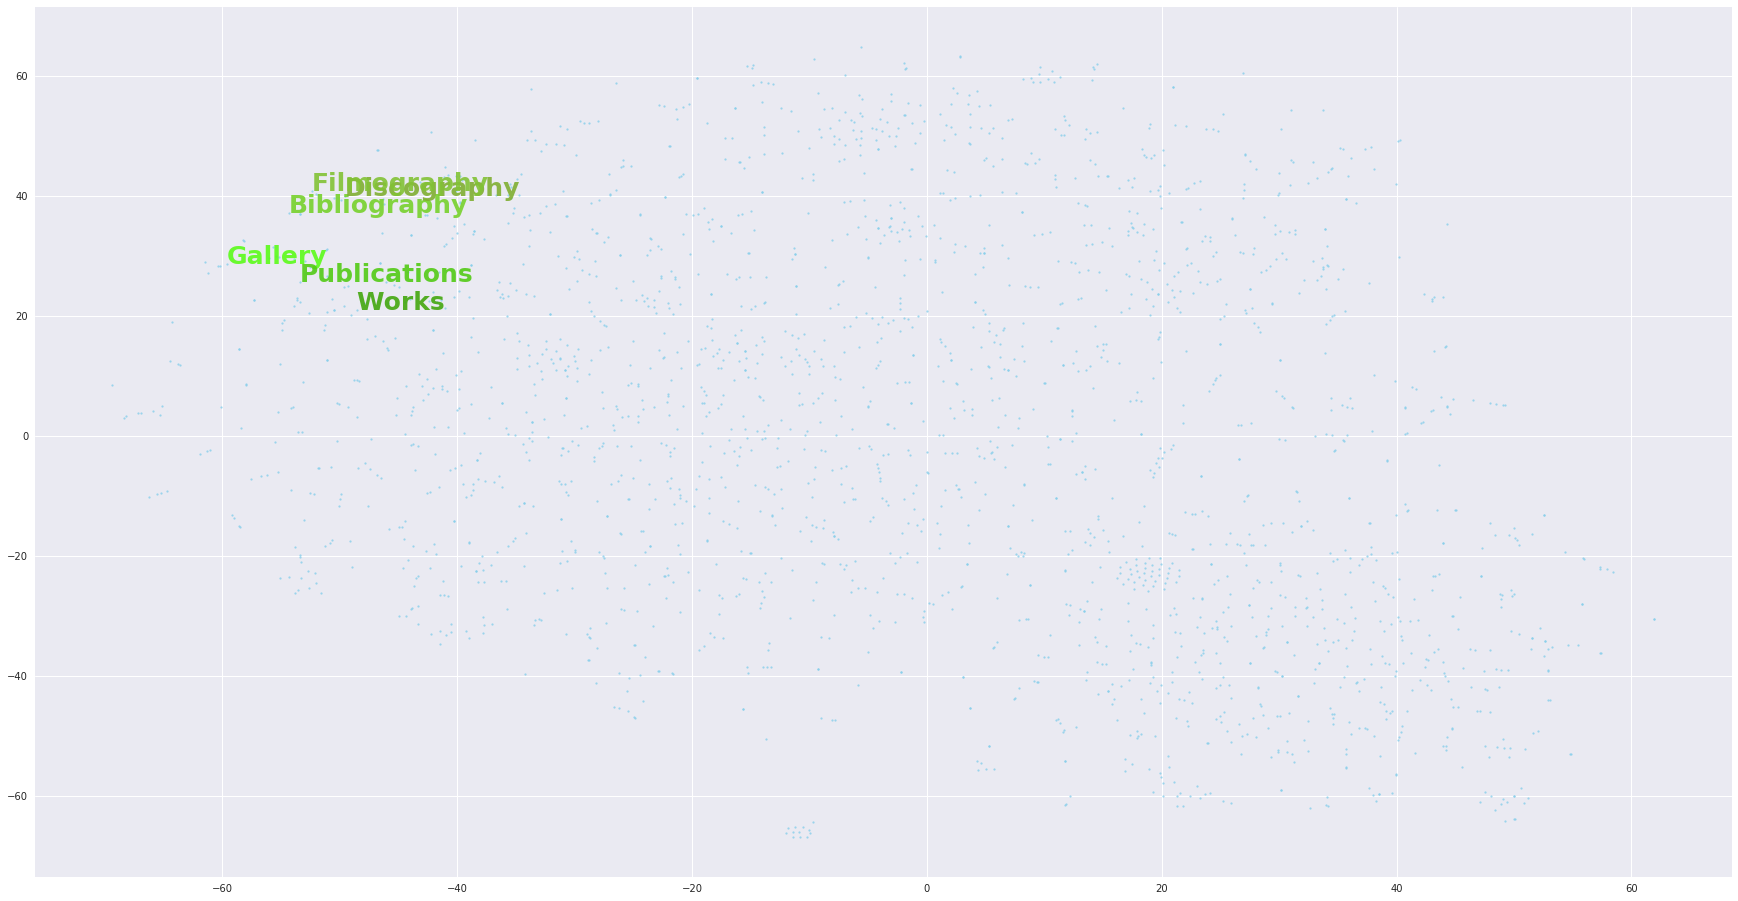

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16*1.9,16)})

p1=sns.regplot(x=X_tsne[:, 0], y=X_tsne[:, 1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':5})


for n,section in enumerate(secsPerlang['en'][0:40]): 
    if section in ['Discography','Filmography','Gallery','Bibliography','Works','Publications']:
        p1.text(X_tsne[n,0], X_tsne[n,1], section, horizontalalignment='left', size=25, color=(abs(X_tsne[n,1])/80,(X_tsne[n,0]**2)/60**2,(X_tsne[n,1])**2/90**2),alpha=0.9, weight='bold')


p1.figure.savefig('SectionTSNE_Subset.png',bbox_inches='tight')


### Plot the same subset in Spanish and English

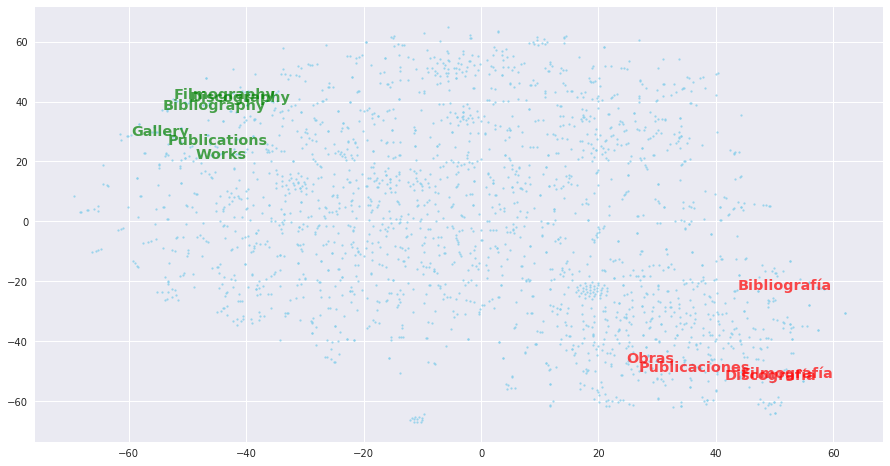

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8*1.9,8)})

p1=sns.regplot(x=X_tsne[:, 0], y=X_tsne[:, 1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':5})
p1.axes.set_xlabel = []
for n,section in enumerate(secsPerlang['en'][0:40]): 
    if section in ['Discography','Filmography','Gallery','Bibliography','Works','Publications']:
         p1.text(X_tsne[n,0], X_tsne[n,1], section, horizontalalignment='left', size='large', color='green',alpha=0.7, weight='bold')

for n,section in enumerate(secsPerlang['es']): 
    n += len(secsPerlang['en']) #note that the position of in the X_tsne array for 'es' is len(en) + pos in es
    if section in ['Discografía','Filmografía','Bibliografía','Publicaciones','Obras']:
        p1.text(X_tsne[n,0], X_tsne[n,1], section, horizontalalignment='left', size='large', color='red',alpha=0.7, weight='bold')

p1.figure.savefig('SectionTSNE_notAligned.png',bbox_inches='tight')


##  Align vectors 

In [189]:
vecsPerLang['es'].apply_transform('fastText_multilingual/alignment_matrices/es.txt')
vecsPerLang['en'].apply_transform('fastText_multilingual/alignment_matrices/en.txt')

In [191]:
embeddingsAligned = {}
for lang, secsSelected in secsPerlang.items():
    print(lang)
    embeddingsAligned[lang] = [createVector(s,vecsPerLang[lang]) for s in secsSelected]


en
es


In [247]:
X_tsne_aligned = TSNE(learning_rate=1000,random_state=4).fit_transform(embeddingsAligned['en']+embeddingsAligned['es'])


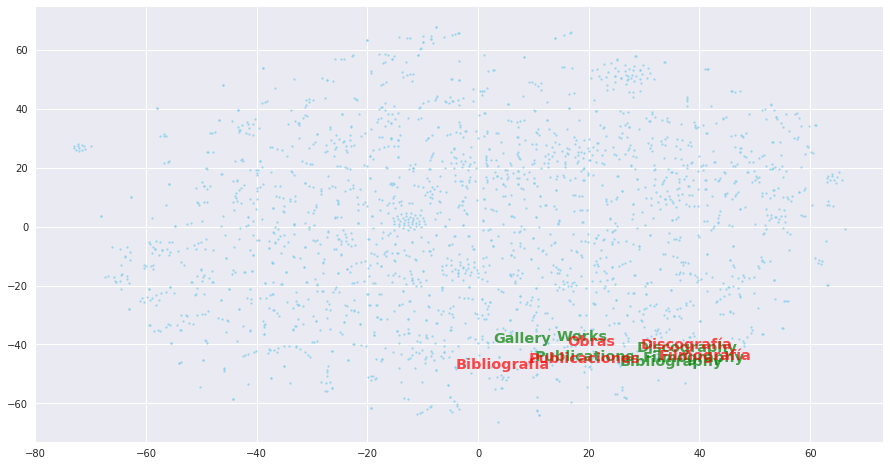

In [287]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8*1.9,8)})

p1=sns.regplot(x=X_tsne_aligned[:, 0], y=X_tsne_aligned[:, 1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':5})
#p1.axes.set_xlim(-40,60)
#p1.axes.set_ylim(-55,36)

for n,section in enumerate(secsPerlang['en'][0:40]): 
    if section in ['Discography','Filmography','Gallery','Bibliography','Works','Publications']:
         p1.text(X_tsne_aligned[n,0], X_tsne_aligned[n,1], section, horizontalalignment='left', size='large', color='green',alpha=0.7, weight='bold')

for n,section in enumerate(secsPerlang['es']):
    n += len(secsPerlang['en'])
    if section in ['Discografía','Filmografía','Bibliografía','Publicaciones','Obras']:
        p1.text(X_tsne_aligned[n,0], X_tsne_aligned[n,1], section, horizontalalignment='left', size='large', color='red',alpha=0.7, weight='bold')

p1.figure.savefig('SectionTSNE_Aligned.png',bbox_inches='tight')